# Lab 1 - Pruning
## Goals
- Understand the basic concept of pruning
- Implement and apply **Fine-grained Pruning**
- Implement and apply **chanel Pruning**
- Get a basis understanding of performance improvement(such as speedup)from pruning
- Understand the difference and tradeoffs between these pruning approaches.



## Contents.
### Two main sections: Fine-grained Pruning and Chaneel Pruning.

There are 9 questions in total:  

- For Fine-grained Pruning, there are 5 questions (Question 1-5).  
- For Channel Pruning, there are 3 questions (Question 6-8).  
- Question 9 compares fine-grained pruning and channel pruning.


## Setup
Install the required packages and download the datasets and pretrained mdoel.    

use CIFAR10 and VGG network

In [ ]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
All required packages have been successfully installed!


In [ ]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

# assert torch.cuda.is_available(), \
# "The current runtime does not have CUDA support." \
# "Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys, ssl
    from urllib.request import urlretrieve
    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None


In [ ]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

In [ ]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [ ]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Helper Functions (Flops, Model Size calculation, etc.)

In [ ]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

**Define misc Functions for verification.**


In [ ]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')


Load the pre-trained model and the CIFAR-10 dataset.

In [ ]:
# Before running next code, I fixed colab option(Ensure GPU is Enabled in Colab)
checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda() # Now this should work
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(checkpoint['state_dict'])

Downloading: "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth" to ./vgg.cifar.pretrained.pth


=> loading checkpoint 'https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


In [ ]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )


100%|██████████| 170498071/170498071 [00:13<00:00, 13061166.70it/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified


## First Evaluate the Accuracy and Model Size of Dense Model


Neural networks have become ubiquitous in many applications.   



In [ ]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%
dense model has size=35.20 MiB


While large neural networks are very powerful, their size consumes considerable storage, memory bandwidth, and computational resources. As we can see from the results above, a model for the task as simple as classifying
 images into 10 classes can be as large as 35 MiB. For embedded mobile applications, these resource demands become prohibitive.  

Therefore, neural network pruning is exploited to facilitates storage and transmission of mobile applications incorporating DNNs.  

The goal of pruning is to reduce the model size while maintaining the accuracy.  

## Distribution of weight values

see the distribution of weight values in the dense model.

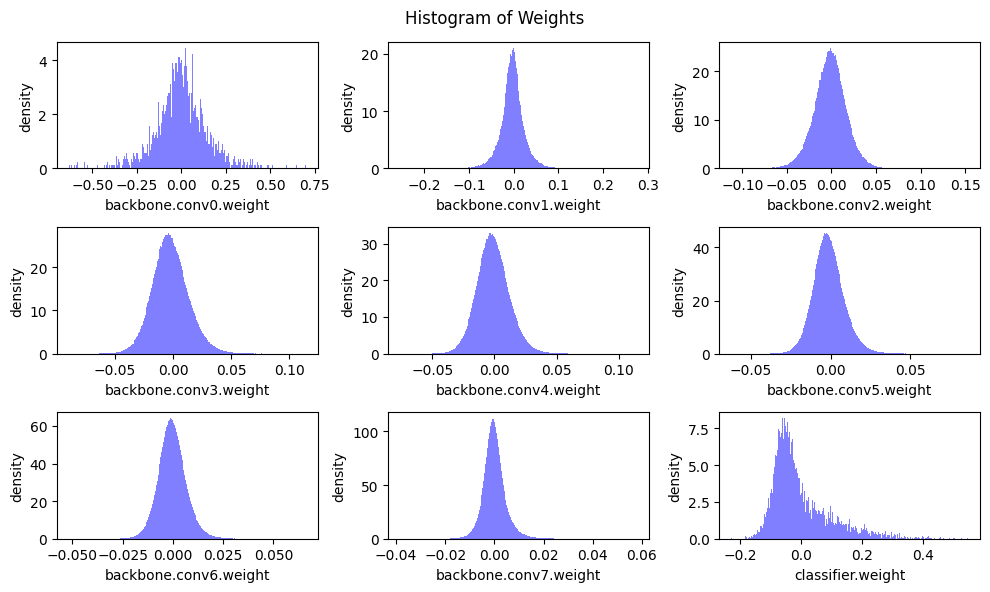

In [ ]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

### Relationship Between Model Size and Performance:  

The graph likely illustrates the relationship between the size of the neural network (in terms of memory usage or the number of parameters) and its performance (accuracy).
Generally, as the model size increases, the performance tends to improve, but this also leads to increased storage requirements and computational resources.    


### Effect of Pruning:

The graph may visualize the changes in model size and performance after applying pruning.  
Pruning involves removing unnecessary weights or neurons from the model, which reduces the model's size.  
The graph likely compares the model size reduction and the extent to which the performance (accuracy) is maintained before and after pruning.  
Ideally, the model size is significantly reduced with minimal impact on accuracy, making the model more efficient for mobile applications.  


### Resource Savings:

The graph might also show the reduction in storage space, memory bandwidth, and computational resources achieved through pruning.  
This highlights the importance of pruning in making neural network models more efficient for execution in mobile and embedded environments.  


### Summary:

The graph likely provides a visual representation of the effects of pruning on a neural network.
Specifically:

- Model Size Reduction: It shows how pruning reduces the model's storage space and memory usage.  

- Performance Maintenance: It indicates that even with reduced model size, the accuracy or other performance metrics are not significantly degraded.  

-  Importance of Resource Savings: It emphasizes how crucial pruning is for efficiently utilizing neural networks in mobile and embedded applications.


### Question 1 (10 pts).
Please answer the following questions using the information in the above histograms of weights.

### Question 1.1 (5 pts)
What are the common characteristics of the weight distribution in the different layers?

Answer:   
- Bell-shaped Distribution: Most layers exhibit a bell-shaped distribution, which is symmetric around zero. This indicates that the majority of the weights are centered around zero with fewer weights having large positive or negative values.

- High Density Near Zero: The majority of the weights are concentrated near zero, especially in the deeper layers. This suggests that many weights contribute minimally to the output and have low magnitude.

- Narrower Distributions in Deeper Layers: As we move to deeper layers (e.g., conv5, conv6, etc.), the weight distributions become narrower, indicating that weights in these layers tend to have smaller magnitudes compared to the earlier layers.

### Question 1.2 (5 pts)
How do these characteristics help pruning?

Answer:
- Low-Magnitude Weights: Since many weights are clustered around zero with low magnitude, they contribute little to the network's output. Pruning these low-magnitude weights will likely have a minimal impact on the network's performance, allowing for an effective reduction in model size without substantial accuracy loss.

- Redundancy Reduction: The bell-shaped distributions and the concentration of weights around zero suggest that there is redundancy in the network. By pruning weights that are near zero, the network can be simplified while retaining its essential characteristics, thus reducing redundancy.

- Efficient Pruning in Deeper Layers: The narrower distributions in deeper layers indicate that these layers have many small weights. Pruning these small weights in deeper layers can lead to a significant reduction in model complexity and computational cost, making the network more efficient, especially for deployment on resource-constrained devices.


## Fine-grained Pruning

In this section, we will implement and perform fine-grained pruning.

Fine-grained pruning removes the synapses with lowest importance. The weight tensor
 will become sparse after fine-grained pruning, which can be described with sparsity:


> 인용구 추가
sparsity := #Zeros/#𝑊  = 1 - #Nonzeros/#𝑊


where #𝑊 is the number of elements in 𝑊
.



Question 2 (15 pts)
Please complete the following magnitude-based fine-grained pruning function.

Hint:

In step 1, we calculate the number of zeros (num_zeros) after pruning. Note that num_zeros should be an integer. You could use either round() or int() to convert a floating number into an integer. Here we use round().
In step 2, we calculate the importance of weight tensor. Pytorch provides torch.abs(), torch.Tensor.abs(), torch.Tensor.abs_() APIs.
In step 3, we calculate the pruning threshold so that all synapses with importance smaller than threshold will be removed. Pytorch provides torch.kthvalue(), torch.Tensor.kthvalue(), torch.topk() APIs.
In step 4, we calculate the pruning mask based on the threshold. 1 in the mask indicates the synapse will be kept, and 0 in the mask indicates the synapse will be removed. mask = importance > threshold. Pytorch provides torch.gt() API.

In [15]:
# my answer
import torch

def magnitude_based_pruning(weight_tensor, pruning_ratio):
    # Step 1: Calculate number of zeros (num_zeros) after pruning
    total_elements = weight_tensor.numel()  # Total number of elements in the tensor
    num_zeros = round(total_elements * pruning_ratio)  # Calculate the number of elements to prune

    # Step 2: Calculate the importance of weight tensor
    importance = torch.abs(weight_tensor)  # Calculate the absolute value (importance) of the weights

    # Step 3: Calculate the pruning threshold
    threshold, _ = torch.kthvalue(importance.view(-1), num_zeros)  # Find the kth smallest value as threshold

    # Step 4: Calculate the pruning mask
    mask = torch.gt(importance, threshold)  # Create a mask where values greater than threshold are 1, else 0

    return mask

# Example usage
weight_tensor = torch.randn(10, 10)  # Randomly initialized weight tensor
pruning_ratio = 0.2  # Prune 20% of the smallest weights
pruning_mask = magnitude_based_pruning(weight_tensor, pruning_ratio)

# Apply the mask to the weight tensor
pruned_weights = weight_tensor * pruning_mask.float()
print(pruned_weights)


tensor([[-1.9627, -0.4790,  1.4107,  0.6427, -1.5467,  0.5543, -0.0000,  0.9749,
         -0.4754, -1.7334],
        [ 0.7497,  0.2540,  0.0000,  0.4518,  0.8193, -0.7732, -3.0466, -0.5341,
         -0.0000, -0.0000],
        [ 0.0000, -0.2561, -2.7803, -0.0000, -0.9816,  1.4136,  1.2822,  0.6004,
         -0.8012,  0.4735],
        [ 0.0000, -1.8666, -0.2660, -0.6449,  1.2855, -0.3003,  0.3616,  0.6189,
          0.0000, -0.6955],
        [-0.7694, -0.0000,  1.0057,  0.0000, -0.2667, -1.5331,  0.0000, -1.3969,
          0.0000, -0.3719],
        [-0.5229, -0.0000,  1.4460, -1.8527, -1.6546, -1.0696,  1.5767,  1.3989,
          2.3169,  1.4592],
        [ 1.9733,  1.5031,  1.9382, -2.1709, -1.0943,  1.8956,  0.0000, -1.0226,
          2.2261,  0.9608],
        [-1.7479,  1.3509, -0.5676, -0.3286, -0.7472,  1.4895, -0.6621, -0.3486,
          1.6783,  0.0000],
        [-0.0000, -0.9389,  1.6502,  0.0000, -0.0000, -0.7475, -0.4527, -1.5233,
         -0.3203, -0.4787],
        [ 0.0000,  

In [16]:
# suggested answer
def fine_grained_prune(tensor: torch.Tensor, sparsity: float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(num_elements * sparsity)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    # Step 3: calculate the pruning threshold
    threshold = torch.kthvalue(importance.flatten(), num_zeros)[0]
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = importance > threshold
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

**verify the functionality of defined fine-grained pruning by applying the function above on a dummy tensor.**

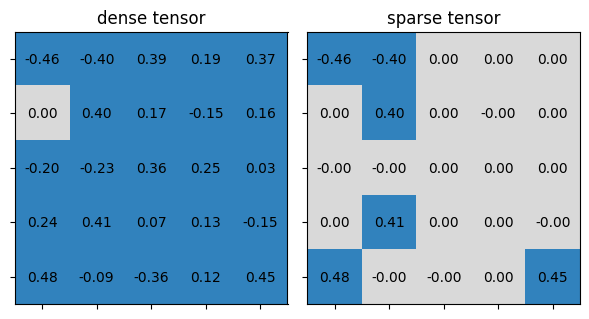

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [18]:
test_fine_grained_prune()

# Graph Interpretation
1. Dense Tensor (Left)
The dense tensor represents the tensor before pruning is applied.
This tensor has most of its elements with actual values (non-zero values) distributed throughout.
2. Sparse Tensor (Right)
The sparse tensor represents the tensor after pruning is applied.
In this tensor, many elements have been set to zero, with only a few elements retaining non-zero values.
This indicates that pruning has removed the weights with lower importance. Pruning reduces the model size and computational load by eliminating less important weights.
Details
Sparsity Before Pruning: The sparsity before pruning was 0.04, meaning that approximately 4% of the tensor's elements were zero.
Sparsity After Pruning: The sparsity after pruning is 0.76, indicating that 76% of the tensor's elements have been set to zero, showing that a significant number of weights were removed during pruning.
Sparsity of Pruning Mask: The sparsity of the pruning mask is also 0.76, meaning the pruning mask was set to remove weights from 76% of the tensor.  

### Summary
This graph shows how pruning compresses a tensor by setting most of its values to zero, thereby optimizing the model. Pruning is done to save computational resources and optimize the model under the assumption that only certain weights are important, and the rest can be removed. As seen in the graph, many values were eliminated, making the tensor significantly more sparse.